![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/32.1.Medical_Text_Summarization_with_Abstractive_Approach.ipynb)



# **Medical Text Summarization**

MedicalSummarizer annotator that uses a type of transformative model, the T5 model, to create a concise summary of medical text given in a clinical context. This annotator helps to quickly summarize complex medical information.


# 📍Benchmark Report

Our clinical summarizer models with only 250M parameters perform 30-35% better than non-clinical SOTA text summarizers with 500M parameters, in terms of Bleu and Rouge benchmarks. That is, we achieve 30% better with half of the parameters that other LLMs have. See the details below.

## 🔎Benchmark on Samsum Dataset
| model_name | model_size | rouge | bleu | bertscore_precision | bertscore_recall: | bertscore_f1 |
|--|--|--|--|--|--|--|
philschmid/flan-t5-base-samsum | 240M | 0.2734 | 0.1813 | 0.8938 | 0.9133 | 0.9034 |
linydub/bart-large-samsum | 500M | 0.3060 | 0.2168 | 0.8961 | 0.9065 | 0.9013 |
philschmid/bart-large-cnn-samsum | 500M | 0.3794 | 0.1262 | 0.8599 | 0.9153 | 0.8867 |
transformersbook/pegasus-samsum | 570M | 0.3049 | 0.1543 | 0.8942 | 0.9183 | 0.9061 |
summarizer_generic_jsl | 240M | 0.2703 | 0.1932 | 0.8944 | 0.9161 | 0.9051 |

## 🔎Benchmark on MtSamples Summarization Dataset
| model_name | model_size | rouge | bleu | bertscore_precision | bertscore_recall: | bertscore_f1 |
|--|--|--|--|--|--|--|
philschmid/flan-t5-base-samsum | 250M | 0.1919 | 0.1124 | 0.8409 | 0.8964 | 0.8678 |
linydub/bart-large-samsum | 500M | 0.1586 | 0.0732 | 0.8747 | 0.8184 | 0.8456 |
philschmid/bart-large-cnn-samsum |  500M | 0.2170 | 0.1299 | 0.8846 | 0.8436 | 0.8636 |
transformersbook/pegasus-samsum | 500M | 0.1924 | 0.0965 | 0.8920 | 0.8149 | 0.8517 |
summarizer_clinical_jsl | 250M | 0.4836 | 0.4188 | 0.9041 | 0.9374 | 0.9204 |
summarizer_clinical_jsl_augmented | 250M | 0.5119 | 0.4545 | 0.9282 | 0.9526 | 0.9402 |

## 🔎Benchmark on MIMIC Summarization Dataset
| model_name | model_size | rouge | bleu | bertscore_precision | bertscore_recall: | bertscore_f1 |
|--|--|--|--|--|--|--|
philschmid/flan-t5-base-samsum | 250M | 0.1910 | 0.1037 | 0.8708 | 0.9056 | 0.8879 |
linydub/bart-large-samsum | 500M | 0.1252 | 0.0382 | 0.8933 | 0.8440 | 0.8679 |
philschmid/bart-large-cnn-samsum | 500M | 0.1795 | 0.0889 | 0.9172 | 0.8978 | 0.9074 |
transformersbook/pegasus-samsum | 570M | 0.1425 | 0.0582 | 0.9171 | 0.8682 | 0.8920 |
summarizer_clinical_jsl | 250M | 0.395 | 0.2962 | 0.895 | 0.9316 | 0.913 |
summarizer_clinical_jsl_augmented | 250M | 0.3964 | 0.307 | 0.9109 | 0.9452 | 0.9227 |

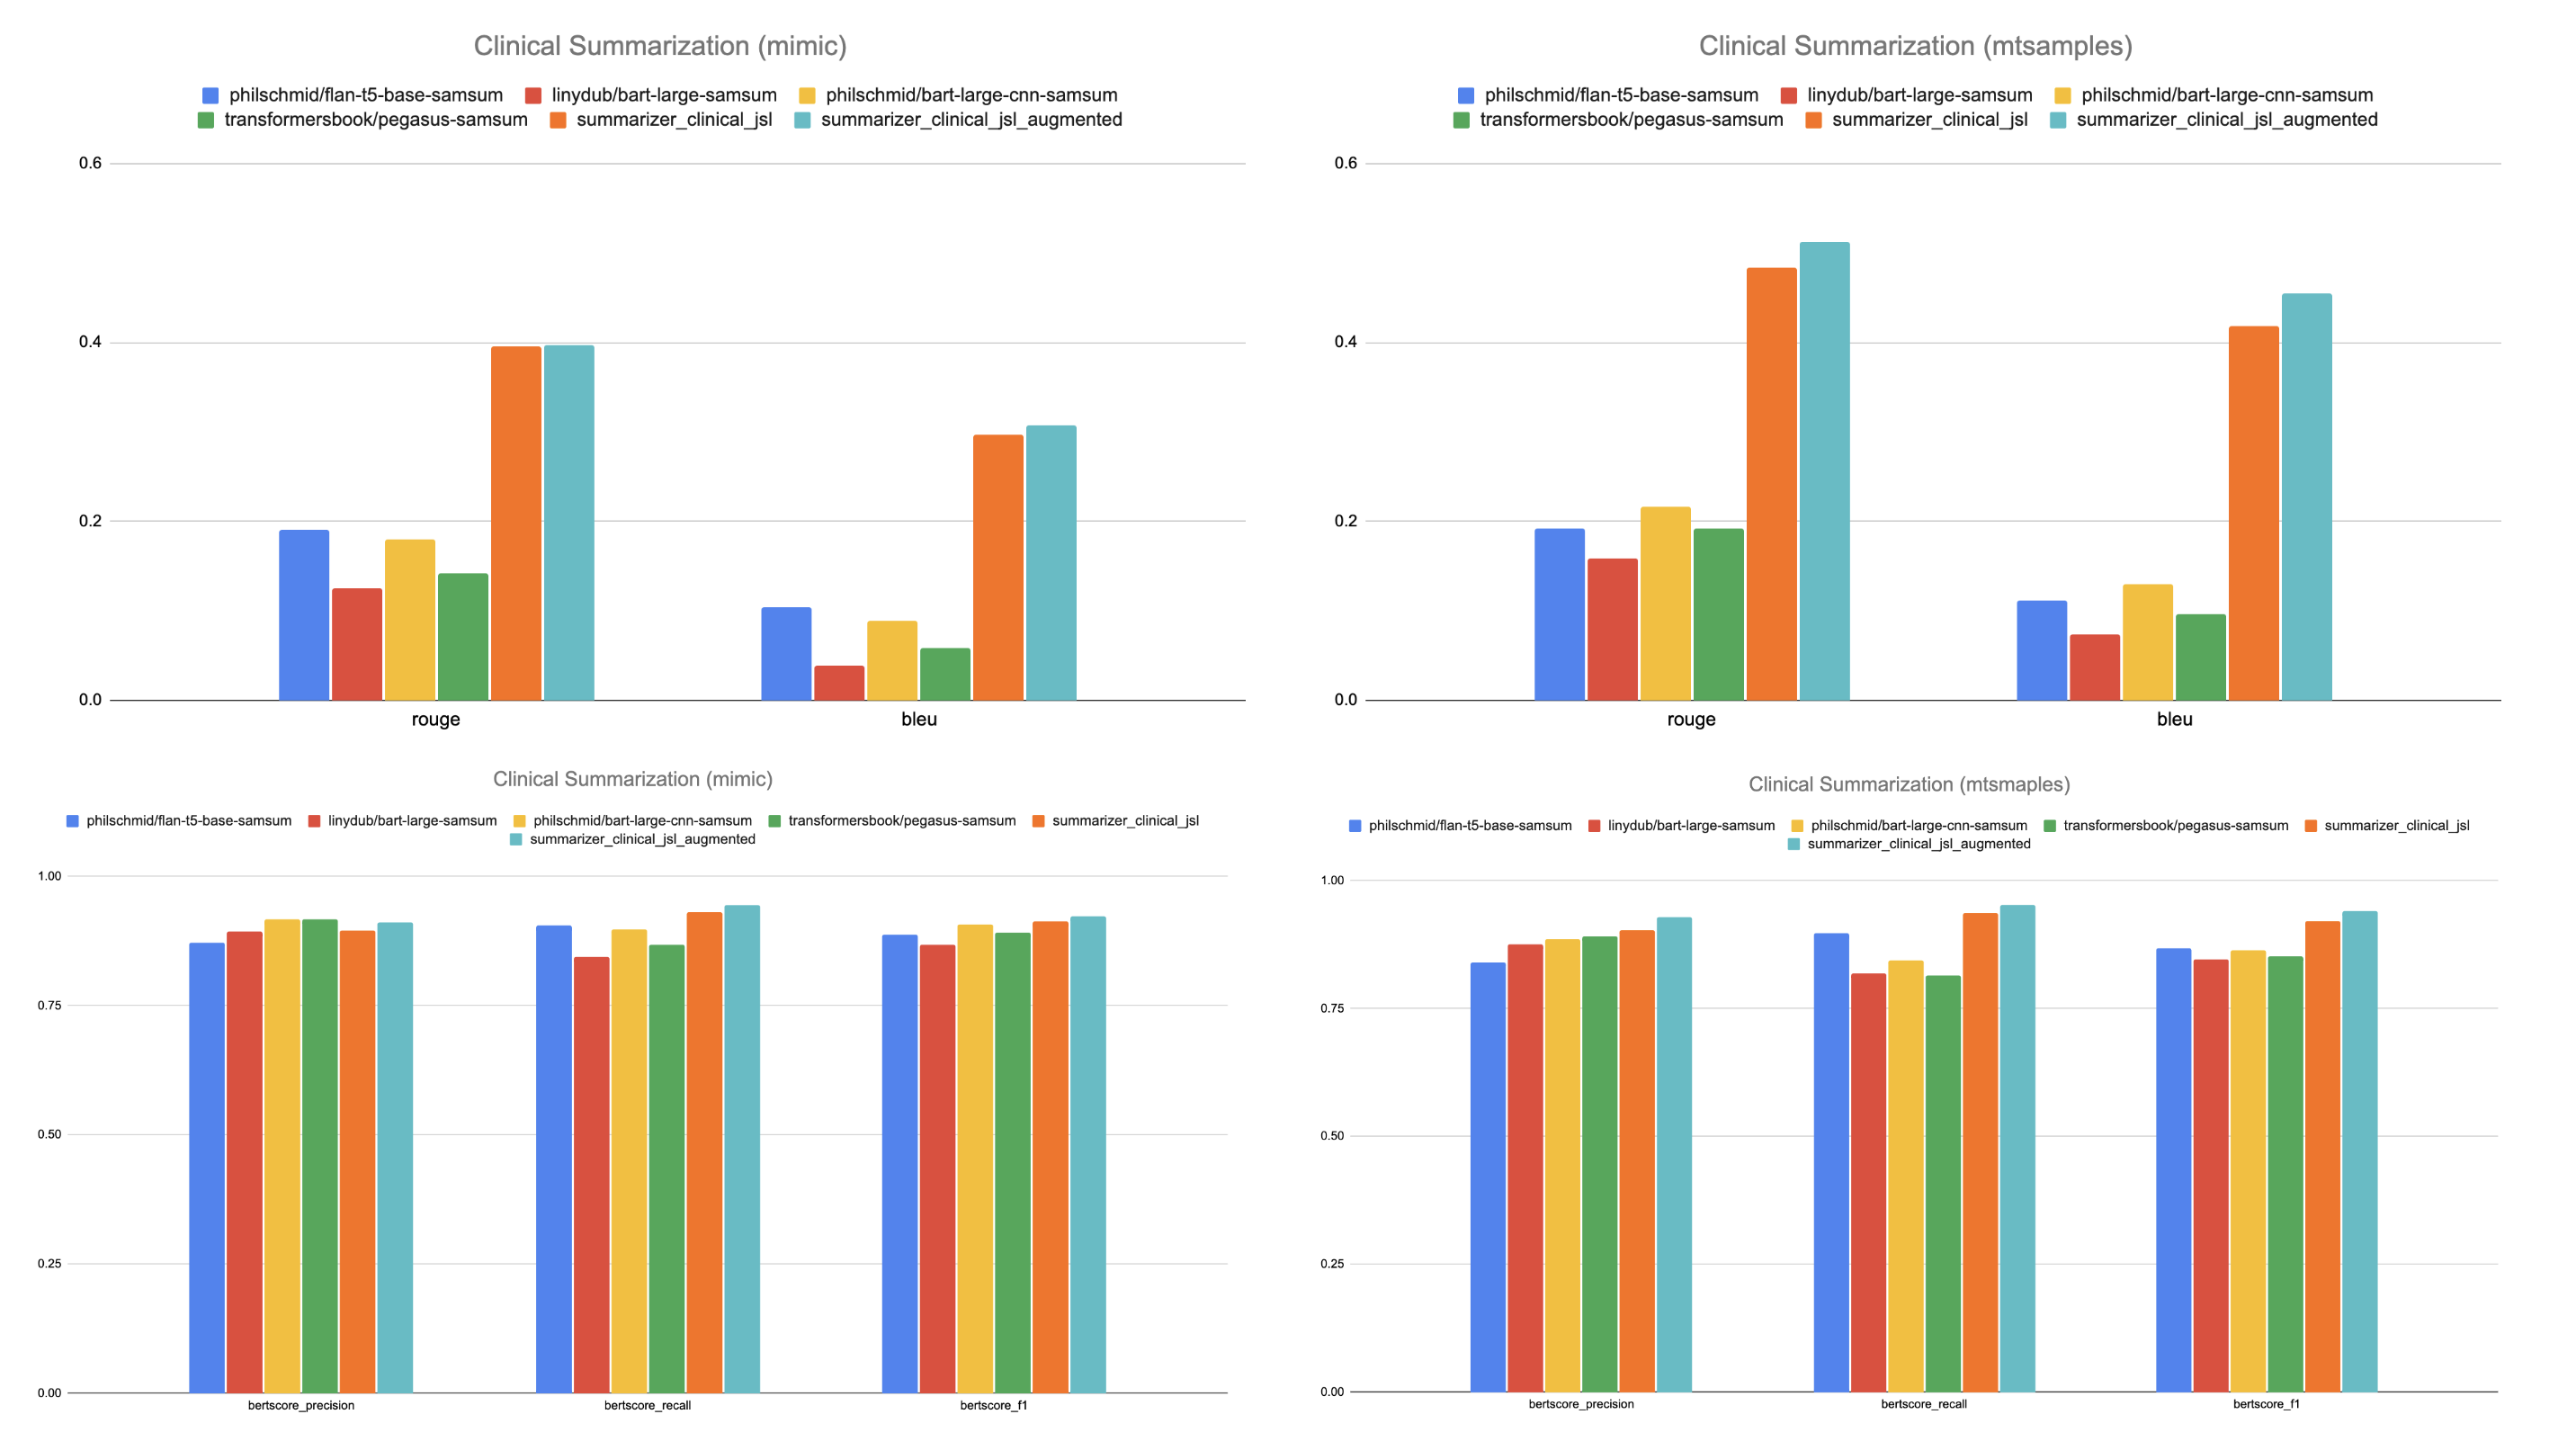

## Colab Setup

📌To run this yourself, you will need to upload your license keys to the notebook. Just Run The Cell Below in order to do that. Also You can open the file explorer on the left side of the screen and upload `license_keys.json` to the folder that opens.
Otherwise, you can look at the example outputs at the bottom of the notebook.

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2  spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import json
import os

from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

import sparknlp
import sparknlp_jsl

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import string
import numpy as np

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.serializer": "org.apache.spark.serializer.KryoSerializer",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 5.0.0
Spark NLP_JSL Version : 5.0.0


# 🔎 MODELS

<div align="center">

| **Index** | **Summarizer Models**        |
|---------------|----------------------|
| 1        | [summarizer_clinical_jsl](https://nlp.johnsnowlabs.com/2023/03/25/summarizer_clinical_jsl.html)     |
| 2          | [summarizer_clinical_jsl_augmented](https://nlp.johnsnowlabs.com/2023/03/30/summarizer_clinical_jsl_augmented_en.html)       |
| 3      | [summarizer_biomedical_pubmed](https://nlp.johnsnowlabs.com/2023/04/03/summarizer_biomedical_pubmed_en.html)    |
| 4      | [summarizer_generic_jsl](https://nlp.johnsnowlabs.com/2023/03/30/summarizer_generic_jsl_en.html)    |
| 5    | [summarizer_clinical_questions](https://nlp.johnsnowlabs.com/2023/04/03/summarizer_clinical_questions_en.html) |
| 6    | [summarizer_radiology](https://nlp.johnsnowlabs.com/2023/04/23/summarizer_jsl_radiology_en.html) |
| 7    | [summarizer_clinical_guidelines_large](https://nlp.johnsnowlabs.com/2023/05/08/summarizer_clinical_guidelines_large_en.html) |
| 8    | [summarizer_clinical_laymen]() |
</div>

# 📃 summarizer_clinical_jsl

Summarize clinical notes, encounters, critical care notes, discharge notes, reports, etc.

In [4]:
text = """ Patient with hypertension, syncope, and spinal stenosis - for recheck.
 (Medical Transcription Sample Report)
 SUBJECTIVE:
 The patient is a 78-year-old female who returns for recheck. She has hypertension. She denies difficulty with chest pain, palpations, orthopnea, nocturnal dyspnea, or edema.
 PAST MEDICAL HISTORY / SURGERY / HOSPITALIZATIONS:
 Reviewed and unchanged from the dictation on 12/03/2003.
 MEDICATIONS:
 Atenolol 50 mg daily, Premarin 0.625 mg daily, calcium with vitamin D two to three pills daily, multivitamin daily, aspirin as needed, and TriViFlor 25 mg two pills daily. She also has Elocon cream 0.1% and Synalar cream 0.01% that she uses as needed for rash."""


data = spark.createDataFrame([[text]]).toDF("text")
data.show(truncate = 60)

+------------------------------------------------------------+
|                                                        text|
+------------------------------------------------------------+
| Patient with hypertension, syncope, and spinal stenosis ...|
+------------------------------------------------------------+



In [5]:
document_assembler = DocumentAssembler()\
            .setInputCol('text')\
            .setOutputCol('document')

summarizer = MedicalSummarizer.pretrained("summarizer_clinical_jsl", "en", "clinical/models")\
            .setInputCols(['document'])\
            .setOutputCol('summary')\
            .setMaxTextLength(512)\
            .setMaxNewTokens(512)


pipeline = Pipeline(stages=[
            document_assembler,
            summarizer])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

result = model.transform(data)
result.show()

summarizer_clinical_jsl download started this may take some time.
[OK!]
+--------------------+--------------------+--------------------+
|                text|            document|             summary|
+--------------------+--------------------+--------------------+
| Patient with hyp...|[{document, 0, 68...|[{document, 0, 24...|
+--------------------+--------------------+--------------------+



In [6]:
result.select("summary.result").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[A 78-year-old female with hypertension, syncope, and spinal stenosis returns for recheck. She denies chest pain, palpations, orthopnea, nocturnal dyspnea, or edema. She is on multiple medications and has Elocon cream and Synalar cream for rash.]|
+---

## **📍 LightPipelines**

In [7]:
text = """The patient is a pleasant 17-year-old gentleman who was playing basketball today in gym. Two hours prior to presentation, he started to fall and someone stepped on his ankle and kind of twisted his right ankle and he cannot bear weight on it now. It hurts to move or bear weight. No other injuries noted. He does not think he has had injuries to his ankle in the past.
SOCIAL HISTORY: He does not drink or smoke.
MEDICAL DECISION MAKING:
He had an x-ray of his ankle that showed a small ossicle versus avulsion fracture of the talonavicular joint on the lateral view. He has had no pain over the metatarsals themselves. This may be a fracture based upon his exam. He does want to have me to put him in a splint. He was given Motrin here. He will be discharged home to follow up with Dr. X from Orthopedics.
DISPOSITION: Crutches and splint were administered here. I gave him a prescription for Motrin and some Darvocet if he needs to length his sleep and if he has continued pain to follow up with Dr. X. Return if any worsening problems."""

light_model = LightPipeline(model)
light_result = light_model.annotate(text)
light_result

{'document': ['The patient is a pleasant 17-year-old gentleman who was playing basketball today in gym. Two hours prior to presentation, he started to fall and someone stepped on his ankle and kind of twisted his right ankle and he cannot bear weight on it now. It hurts to move or bear weight. No other injuries noted. He does not think he has had injuries to his ankle in the past.\nSOCIAL HISTORY: He does not drink or smoke.\nMEDICAL DECISION MAKING:\nHe had an x-ray of his ankle that showed a small ossicle versus avulsion fracture of the talonavicular joint on the lateral view. He has had no pain over the metatarsals themselves. This may be a fracture based upon his exam. He does want to have me to put him in a splint. He was given Motrin here. He will be discharged home to follow up with Dr. X from Orthopedics.\nDISPOSITION: Crutches and splint were administered here. I gave him a prescription for Motrin and some Darvocet if he needs to length his sleep and if he has continued pain t

In [8]:
light_result["summary"]

['A 17-year-old man fell and twisted his right ankle, causing pain to move or bear weight. An x-ray showed a small ossicle or avulsion fracture of the talonavicular joint on the lateral view, which may be a fracture based upon his exam. He was given Motrin and discharged home with crutches and a prescription for Motrin and Darvocet. He was advised to follow up with his doctor if pain worsens and return if any worsening problems worsen.']

## 🚩 summaries from paragraphs in text

In [9]:
document_assembler = DocumentAssembler()\
            .setInputCol('text')\
            .setOutputCol('document')

sentenceDetector = SentenceDetectorDLModel\
            .pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
            .setInputCols(["document"])\
            .setOutputCol("sentence")\
            .setCustomBounds(["\n"])\
            .setUseCustomBoundsOnly(True)

summarizer = MedicalSummarizer\
            .pretrained("summarizer_clinical_jsl")\
            .setInputCols(['sentence'])\
            .setOutputCol('summary')\
            .setMaxTextLength(512)\
            .setMaxNewTokens(512)

pipeline = Pipeline(stages=[
            document_assembler,
            sentenceDetector,
            summarizer])

empty_data = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
summarizer_clinical_jsl download started this may take some time.
[OK!]


In [10]:
text = """PRESENT ILLNESS: The patient is a 28-year-old, who is status post gastric bypass surgery nearly one year ago. He has lost about 200 pounds and was otherwise doing well until yesterday evening around 7:00-8:00 when he developed nausea and right upper quadrant pain, which apparently wrapped around toward his right side and back. He feels like he was on it but has not done so. He has overall malaise and a low-grade temperature of 100.3. He denies any prior similar or lesser symptoms. His last normal bowel movement was yesterday. He denies any outright chills or blood per rectum.

PHYSICAL EXAMINATION: His temperature is 100.3, blood pressure 129/59, respirations 16, heart rate 84. He is drowsy, but easily arousable and appropriate with conversation. He is oriented to person, place, and situation. He is normocephalic, atraumatic. His sclerae are anicteric. His mucous membranes are somewhat tacky. His neck is supple and symmetric. His respirations are unlabored and clear. He has a regular rate and rhythm. His abdomen is soft. He has diffuse right upper quadrant tenderness, worse focally, but no rebound or guarding. He otherwise has no organomegaly, masses, or abdominal hernias evident. His extremities are symmetrical with no edema. His posterior tibial pulses are palpable and symmetric. He is grossly nonfocal neurologically.

PLAN: He will be admitted and placed on IV antibiotics. We will get an ultrasound this morning. He will need his gallbladder out, probably with intraoperative cholangiogram. Hopefully, the stone will pass this way. Due to his anatomy, an ERCP would prove quite difficult if not impossible unless laparoscopic assisted. Dr. X will see him later this morning and discuss the plan further. The patient understands."""

light_model = LightPipeline(model)
light_result = light_model.annotate(text)

In [11]:
import textwrap

for i in range(len(light_result['sentence'])):
    document_text = textwrap.fill(light_result['sentence'][i], width=120)
    summary_text = textwrap.fill(light_result['summary'][i], width=120)

    print("➤ Document {}: \n{}".format(i+1, document_text))
    print("\n")
    print("➤ Summary {}: \n{}".format(i+1, summary_text))
    print("\n")

➤ Document 1: 
PRESENT ILLNESS: The patient is a 28-year-old, who is status post gastric bypass surgery nearly one year ago. He has
lost about 200 pounds and was otherwise doing well until yesterday evening around 7:00-8:00 when he developed nausea and
right upper quadrant pain, which apparently wrapped around toward his right side and back. He feels like he was on it
but has not done so. He has overall malaise and a low-grade temperature of 100.3. He denies any prior similar or lesser
symptoms. His last normal bowel movement was yesterday. He denies any outright chills or blood per rectum.


➤ Summary 1: 
A 28-year-old patient who had gastric bypass surgery nearly one year ago developed nausea and right upper quadrant pain,
which wrapped around his right side and back. He has malaise and a low-grade temperature of 100.3. He denies any
previous symptoms and has no other symptoms.


➤ Document 2: 
PHYSICAL EXAMINATION: His temperature is 100.3, blood pressure 129/59, respirations 16, he

## 🚩 setRefineSummary

**We've Made Significant Enhancements To Our Text Summarization Method, Which Now Utilizes A Map-Reduce Approach For Section-Wise Summarization.**

We are excited to announce the integration of new parameters into our `MedicalSummarizer` annotator, empowering users to overcome token limitations and attain heightened flexibility in their medical summarization endeavors. These advanced parameters significantly augment the annotator's functionality, enabling users to generate more accurate and comprehensive summaries of medical documents. By employing a map-reduce approach, the `MedicalSummarizer` efficiently condenses distinct text segments until the desired length is achieved.

The following parameters have been introduced:

- `setRefineSummary`: Set to True for refined summarization with increased computational cost.
- `setRefineSummaryTargetLength`: Define the target length of summarizations in tokens (delimited by whitespace). Effective only when setRefineSummary=True.
- `setRefineChunkSize`: Specify the desired size of refined chunks. Should correspond to the LLM context window size in tokens. Effective only when - `setRefineSummary=True`.
- `setRefineMaxAttempts`: Determine the number of attempts for re-summarizing chunks exceeding the setRefineSummaryTargetLength before discontinuing. Effective only when `setRefineSummary=True`.

These enhancements to the MedicalSummarizer annotator represent our ongoing commitment to providing state-of-the-art tools for healthcare professionals and researchers, facilitating more efficient and accurate medical text analysis.

In [12]:
document_assembler = DocumentAssembler()\
            .setInputCol('text')\
            .setOutputCol('document')

summarizer = MedicalSummarizer.pretrained("summarizer_clinical_jsl", "en", "clinical/models")\
            .setInputCols(["document"])\
            .setOutputCol("summary")\
            .setMaxTextLength(512)\
            .setMaxNewTokens(512)\
            .setDoSample(True)\
            .setRefineSummary(True)\
            .setRefineSummaryTargetLength(100)\
            .setRefineMaxAttempts(3)\
            .setRefineChunkSize(512)

pipeline = Pipeline(stages=[
            document_assembler,
            summarizer])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

summarizer_clinical_jsl download started this may take some time.
[OK!]


In [13]:
text = """The patient is a pleasant 17-year-old gentleman who was playing basketball today in gym. Two hours prior to presentation, he started to fall and someone stepped on his ankle and kind of twisted his right ankle and he cannot bear weight on it now. It hurts to move or bear weight. No other injuries noted. He does not think he has had injuries to his ankle in the past.
SOCIAL HISTORY: He does not drink or smoke.
MEDICAL DECISION MAKING:
He had an x-ray of his ankle that showed a small ossicle versus avulsion fracture of the talonavicular joint on the lateral view. He has had no pain over the metatarsals themselves. This may be a fracture based upon his exam. He does want to have me to put him in a splint. He was given Motrin here. He will be discharged home to follow up with Dr. X from Orthopedics.
DISPOSITION: Crutches and splint were administered here. I gave him a prescription for Motrin and some Darvocet if he needs to length his sleep and if he has continued pain to follow up with Dr. X. Return if any worsening problems."""

light_model = LightPipeline(model)

light_result = light_model.annotate(text)

In [14]:
light_result["summary"]

['An x-ray showed spondylolisis of the ankle in a 17, 17, and 17-months old man who was playing basketball in the gym after slipping. He has no other injury notes, but an anx ray revealed small fracture of the ankle. He requested Moritinos for pain and he was discharged with crutes and Motrinos. The physician gave his sprates & tuxet for resting. He also gave him Motrines, if pain worsenes and advised him on returning for followup.']

In [15]:
import textwrap

for i in range(len(light_result['document'])):
    document_text = textwrap.fill(light_result['document'][i], width=120)
    summary_text = textwrap.fill(light_result['summary'][i], width=120)

    print("➤ Document {}: \n{}".format(i+1, document_text))
    print("\n")
    print("➤ Summary {}: \n{}".format(i+1, summary_text))
    print("\n")

➤ Document 1: 
The patient is a pleasant 17-year-old gentleman who was playing basketball today in gym. Two hours prior to
presentation, he started to fall and someone stepped on his ankle and kind of twisted his right ankle and he cannot bear
weight on it now. It hurts to move or bear weight. No other injuries noted. He does not think he has had injuries to his
ankle in the past. SOCIAL HISTORY: He does not drink or smoke. MEDICAL DECISION MAKING: He had an x-ray of his ankle
that showed a small ossicle versus avulsion fracture of the talonavicular joint on the lateral view. He has had no pain
over the metatarsals themselves. This may be a fracture based upon his exam. He does want to have me to put him in a
splint. He was given Motrin here. He will be discharged home to follow up with Dr. X from Orthopedics. DISPOSITION:
Crutches and splint were administered here. I gave him a prescription for Motrin and some Darvocet if he needs to length
his sleep and if he has continued pain to fo

# 📃 summarizer_clinical_jsl_augmented

In [16]:
document_assembler = DocumentAssembler()\
            .setInputCol('text')\
            .setOutputCol('document')

med_summarizer  = MedicalSummarizer()\
    .pretrained("summarizer_clinical_jsl_augmented")\
    .setInputCols("document")\
    .setOutputCol("summary")\
    .setMaxNewTokens(100)\
    .setMaxTextLength(1024)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = Pipeline(stages=[document_assembler,
                            med_summarizer])


model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
light_model = LightPipeline(model)

summarizer_clinical_jsl_augmented download started this may take some time.
[OK!]


In [17]:
text = """Residual disease after initial surgery for ovarian cancer is the strongest prognostic factor for survival. However, the extent of surgical resection required to achieve optimal cytoreduction is controversial. Our goal was to estimate the effect of aggressive surgical resection on ovarian cancer patient survival.\\n A retrospective cohort study of consecutive patients with International Federation of Gynecology and Obstetrics stage IIIC ovarian cancer undergoing primary surgery was conducted between January 1, 1994, and December 31, 1998. The main outcome measures were residual disease after cytoreduction, frequency of radical surgical resection, and 5-year disease-specific survival.\\n The study comprised 194 patients, including 144 with carcinomatosis. The mean patient age and follow-up time were 64.4 and 3.5 years, respectively. After surgery, 131 (67.5%) of the 194 patients had less than 1 cm of residual disease (definition of optimal cytoreduction). Considering all patients, residual disease was the only independent predictor of survival; the need to perform radical procedures to achieve optimal cytoreduction was not associated with a decrease in survival. For the subgroup of patients with carcinomatosis, residual disease and the performance of radical surgical procedures were the only independent predictors. Disease-specific survival was markedly improved for patients with carcinomatosis operated on by surgeons who most frequently used radical procedures compared with those least likely to use radical procedures (44% versus 17%, P < .001).\\n Overall, residual disease was the only independent predictor of survival. Minimizing residual disease through aggressive surgical resection was beneficial, especially in patients with carcinomatosis."""

light_result = light_model.annotate(text)
light_result

{'document': ['Residual disease after initial surgery for ovarian cancer is the strongest prognostic factor for survival. However, the extent of surgical resection required to achieve optimal cytoreduction is controversial. Our goal was to estimate the effect of aggressive surgical resection on ovarian cancer patient survival.\\n A retrospective cohort study of consecutive patients with International Federation of Gynecology and Obstetrics stage IIIC ovarian cancer undergoing primary surgery was conducted between January 1, 1994, and December 31, 1998. The main outcome measures were residual disease after cytoreduction, frequency of radical surgical resection, and 5-year disease-specific survival.\\n The study comprised 194 patients, including 144 with carcinomatosis. The mean patient age and follow-up time were 64.4 and 3.5 years, respectively. After surgery, 131 (67.5%) of the 194 patients had less than 1 cm of residual disease (definition of optimal cytoreduction). Considering all p

In [18]:
light_result["summary"]

['The study of a patient with stage IIIC ovarian cancer undergoing primary surgery revealed residual disease after initial surgery, frequency of radical surgical resection, and 5-year disease-specific survival. The study showed that aggressive surgical resection was the only independent predictor of survival, with less than 1 cm of residual disease. Disease-specific survival was improved for patients with carcinomatosis operated on by surgeons who most frequently used radical procedures compared to those least likely to use']

# 📃 summarizer_biomedical_pubmed
This model is a modified version of Flan-T5 (LLM) based summarization model that is finetuned with biomedical datasets (Pubmed abstracts) by John Snow Labs.  It can generate summaries up to 512 tokens given an input text (max 1024 tokens).

In [19]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

summarizer = MedicalSummarizer()\
    .pretrained("summarizer_biomedical_pubmed")\
    .setInputCols(["document"])\
    .setOutputCol("summary")\
    .setMaxTextLength(512)\
    .setMaxNewTokens(512)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = sparknlp.base.Pipeline(stages=[
    document_assembler,
    summarizer
])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
light_model = LightPipeline(model)

summarizer_biomedical_pubmed download started this may take some time.
[OK!]


In [20]:
text = """Residual disease after initial surgery for ovarian cancer is the strongest prognostic factor for survival. However, the extent of surgical resection required to achieve optimal cytoreduction is controversial. Our goal was to estimate the effect of aggressive surgical resection on ovarian cancer patient survival.\\n A retrospective cohort study of consecutive patients with International Federation of Gynecology and Obstetrics stage IIIC ovarian cancer undergoing primary surgery was conducted between January 1, 1994, and December 31, 1998. The main outcome measures were residual disease after cytoreduction, frequency of radical surgical resection, and 5-year disease-specific survival.\\n The study comprised 194 patients, including 144 with carcinomatosis. The mean patient age and follow-up time were 64.4 and 3.5 years, respectively. After surgery, 131 (67.5%) of the 194 patients had less than 1 cm of residual disease (definition of optimal cytoreduction). Considering all patients, residual disease was the only independent predictor of survival; the need to perform radical procedures to achieve optimal cytoreduction was not associated with a decrease in survival. For the subgroup of patients with carcinomatosis, residual disease and the performance of radical surgical procedures were the only independent predictors. Disease-specific survival was markedly improved for patients with carcinomatosis operated on by surgeons who most frequently used radical procedures compared with those least likely to use radical procedures (44% versus 17%, P < .001).\\n Overall, residual disease was the only independent predictor of survival. Minimizing residual disease through aggressive surgical resection was beneficial, especially in patients with carcinomatosis."""

light_result = light_model.annotate(text)
light_result

{'document': ['Residual disease after initial surgery for ovarian cancer is the strongest prognostic factor for survival. However, the extent of surgical resection required to achieve optimal cytoreduction is controversial. Our goal was to estimate the effect of aggressive surgical resection on ovarian cancer patient survival.\\n A retrospective cohort study of consecutive patients with International Federation of Gynecology and Obstetrics stage IIIC ovarian cancer undergoing primary surgery was conducted between January 1, 1994, and December 31, 1998. The main outcome measures were residual disease after cytoreduction, frequency of radical surgical resection, and 5-year disease-specific survival.\\n The study comprised 194 patients, including 144 with carcinomatosis. The mean patient age and follow-up time were 64.4 and 3.5 years, respectively. After surgery, 131 (67.5%) of the 194 patients had less than 1 cm of residual disease (definition of optimal cytoreduction). Considering all p

In [21]:
light_result["summary"]

['The results of this review suggest that aggressive ovarian cancer surgery is associated with a significant reduction in the risk of recurrence and a reduction in the number of radical versus conservative surgical resections. However, the results of this review are based on only one small trial. Further research is needed to determine the role of aggressive ovarian cancer surgery in women with stage IIIC ovarian cancer.']

# 📃 summarizer_clinical_questions

This model is a modified version of Flan-T5 (LLM) based summarization model that is finetuned with medical questions exchanged in clinical mediums (clinic, email, call center etc.) by John Snow Labs.  It can generate summaries up to 512 tokens given an input text (max 1024 tokens).

In [22]:
summarizer = MedicalSummarizer()\
    .pretrained("summarizer_clinical_questions")\
    .setInputCols(["document"])\
    .setOutputCol("summary")\
    .setMaxTextLength(512)\
    .setMaxNewTokens(512)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = sparknlp.base.Pipeline(stages=[
    document_assembler,
    summarizer
])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
light_model = LightPipeline(model)

summarizer_clinical_questions download started this may take some time.
[OK!]


In [23]:
text = """
Hello,I'm 20 year old girl. I'm diagnosed with hyperthyroid 1 month ago. I was feeling weak, light headed,poor digestion, panic attacks, depression, left chest pain, increased heart rate, rapidly weight loss, from 4 months. Because of this, I stayed in the hospital and just discharged from hospital. I had many other blood tests, brain mri, ultrasound scan, endoscopy because of some dumb doctors bcs they were not able to diagnose actual problem. Finally I got an appointment with a homeopathy doctor finally he find that i was suffering from hyperthyroid and my TSH was 0.15 T3 and T4 is normal . Also i have b12 deficiency and vitamin D deficiency so I'm taking weekly supplement of vitamin D and 1000 mcg b12 daily. I'm taking homeopathy medicine for 40 days and took 2nd test after 30 days. My TSH is 0.5 now. I feel a little bit relief from weakness and depression but I'm facing with 2 new problem from last week that is breathtaking problem and very rapid heartrate. I just want to know if i should start allopathy medicine or homeopathy is okay? Bcs i heard that thyroid take time to start recover. So please let me know if both of medicines take same time. Because some of my friends advising me to start allopathy and never take a chance as i can develop some serious problems.Sorry for my poor english😐Thank you.
"""

light_result = light_model.annotate(text)
light_result


{'document': ["\nHello,I'm 20 year old girl. I'm diagnosed with hyperthyroid 1 month ago. I was feeling weak, light headed,poor digestion, panic attacks, depression, left chest pain, increased heart rate, rapidly weight loss, from 4 months. Because of this, I stayed in the hospital and just discharged from hospital. I had many other blood tests, brain mri, ultrasound scan, endoscopy because of some dumb doctors bcs they were not able to diagnose actual problem. Finally I got an appointment with a homeopathy doctor finally he find that i was suffering from hyperthyroid and my TSH was 0.15 T3 and T4 is normal . Also i have b12 deficiency and vitamin D deficiency so I'm taking weekly supplement of vitamin D and 1000 mcg b12 daily. I'm taking homeopathy medicine for 40 days and took 2nd test after 30 days. My TSH is 0.5 now. I feel a little bit relief from weakness and depression but I'm facing with 2 new problem from last week that is breathtaking problem and very rapid heartrate. I just 

In [24]:
light_result["summary"]

['What are the treatments for hyperthyroidism?']

# 📃 summarizer_radiology

This model is capable of summarizing radiology reports while preserving the important information.

In [25]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

summarizer = MedicalSummarizer.pretrained("summarizer_radiology", "en", "clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("summary")\
    .setMaxTextLength(512)\
    .setMaxNewTokens(512)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = sparknlp.base.Pipeline(stages=[
    document_assembler,
    summarizer
])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
light_model = LightPipeline(model)

summarizer_radiology download started this may take some time.
[OK!]


In [26]:
text = """INDICATIONS: Peripheral vascular disease with claudication.

RIGHT:
1. Normal arterial imaging of right lower extremity.
2. Peak systolic velocity is normal.
3. Arterial waveform is triphasic.
4. Ankle brachial index is 0.96.

LEFT:
1. Normal arterial imaging of left lower extremity.
2. Peak systolic velocity is normal.
3. Arterial waveform is triphasic throughout except in posterior tibial artery where it is biphasic.
4. Ankle brachial index is 1.06.

IMPRESSION:
Normal arterial imaging of both lower lobes.
"""

light_result = light_model.annotate(text)
light_result


{'document': ['INDICATIONS: Peripheral vascular disease with claudication.\n\nRIGHT:\n1. Normal arterial imaging of right lower extremity.\n2. Peak systolic velocity is normal.\n3. Arterial waveform is triphasic.\n4. Ankle brachial index is 0.96.\n\nLEFT:\n1. Normal arterial imaging of left lower extremity.\n2. Peak systolic velocity is normal.\n3. Arterial waveform is triphasic throughout except in posterior tibial artery where it is biphasic.\n4. Ankle brachial index is 1.06.\n\nIMPRESSION:\nNormal arterial imaging of both lower lobes.\n'],
 'summary': ['The patient has peripheral vascular disease with claudication. The right lower extremity shows normal arterial imaging, but the peak systolic velocity is normal. The arterial waveform is triphasic throughout, except for the posterior tibial artery, which is biphasic. The ankle brachial index is 0.96. The impression is normal arterial imaging of both lower lobes.']}

In [27]:
light_result["summary"]

['The patient has peripheral vascular disease with claudication. The right lower extremity shows normal arterial imaging, but the peak systolic velocity is normal. The arterial waveform is triphasic throughout, except for the posterior tibial artery, which is biphasic. The ankle brachial index is 0.96. The impression is normal arterial imaging of both lower lobes.']

# 📃 summarizer_clinical_guidelines_large

This innovative Medical Summarizer Model is adept at providing succinct summarizations of clinical guidelines.

In [4]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

summarizer = MedicalSummarizer.pretrained("summarizer_clinical_guidelines_large", "en", "clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("summary")\
    .setMaxTextLength(768)\
    .setMaxNewTokens(512)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = Pipeline(stages=[
    document,
    summarizer
])

summarizer_clinical_guidelines_large download started this may take some time.
[OK!]


In [5]:
text = """Clinical Guidelines for Breast Cancer:
Breast cancer is the most common type of cancer among women. It occurs when the cells in the breast start growing abnormally, forming a lump or mass. This can result in the spread of cancerous cells to other parts of the body. Breast cancer may occur in both men and women but is more prevalent in women.
The exact cause of breast cancer is unknown. However, several risk factors can increase your likelihood of developing breast cancer, such as:
- A personal or family history of breast cancer
- A genetic mutation, such as BRCA1 or BRCA2
- Exposure to radiation
- Age (most commonly occurring in women over 50)
- Early onset of menstruation or late menopause
- Obesity
- Hormonal factors, such as taking hormone replacement therapy
Breast cancer may not present symptoms during its early stages. Symptoms typically manifest as the disease progresses. Some notable symptoms include:
- A lump or thickening in the breast or underarm area
- Changes in the size or shape of the breast
- Nipple discharge
- Nipple changes in appearance, such as inversion or flattening
- Redness or swelling in the breast
Treatment for breast cancer depends on several factors, including the stage of the cancer, the location of the tumor, and the individual's overall health. Common treatment options include:
- Surgery (such as lumpectomy or mastectomy)
- Radiation therapy
- Chemotherapy
- Hormone therapy
- Targeted therapy
Early detection is crucial for the successful treatment of breast cancer. Women are advised to routinely perform self-examinations and undergo regular mammogram testing starting at age 40. If you notice any changes in your breast tissue, consult with your healthcare provider immediately."""

data = spark.createDataFrame([[text]]).toDF("text")
data.show(truncate = 60)

+------------------------------------------------------------+
|                                                        text|
+------------------------------------------------------------+
|Clinical Guidelines for Breast Cancer:
Breast cancer is t...|
+------------------------------------------------------------+



In [6]:
model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

result = model.transform(data)
result.show()

+--------------------+--------------------+--------------------+
|                text|            document|             summary|
+--------------------+--------------------+--------------------+
|Clinical Guidelin...|[{document, 0, 17...|[{document, 0, 12...|
+--------------------+--------------------+--------------------+



In [7]:
result.select("summary.result").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 📃 summarizer_clinical_laymen

This model is a modified version of Flan-T5 (LLM) based summarization model that is finetuned with custom dataset by John Snow Labs to avoid using clinical jargon on the summaries.  It can generate summaries up to 512 tokens given an input text (max 1024 tokens).

In [8]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

summarizer = MedicalSummarizer.pretrained("summarizer_clinical_laymen", "en", "clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("summary")\
    .setMaxNewTokens(512)\
    .setRefineSummary(True)\
    .setRefineSummaryTargetLength(100)\
    .setRefineMaxAttempts(3)\
    .setRefineChunkSize(512)

pipeline = Pipeline(stages=[
    document_assembler,
    summarizer
])

summarizer_clinical_laymen download started this may take some time.
[OK!]


In [9]:
text ="""Olivia Smith was seen in my office for evaluation for elective surgical weight loss on October 6, 2008. Olivia Smith is a 34-year-old female with a BMI of 43. She is 5'6" tall and weighs 267 pounds. She is motivated to attempt surgical weight loss because she has been overweight for over 20 years and wants to have more energy and improve her self-image. She is not only affected physically, but also socially by her weight. When she loses weight she always regains it and she always gains back more weight than she has lost. At one time, she lost 100 pounds and gained the weight back within a year. She has tried numerous commercial weight loss programs including Weight Watcher's for four months in 1992 with 15-pound weight loss, RS for two months in 1990 with six-pound weight loss, Slim Fast for six weeks in 2004 with eight-pound weight loss, an exercise program for two months in 2007 with a five-pound weight loss, Atkin's Diet for three months in 2008 with a ten-pound weight loss, and Dexatrim for one month in 2005 with a five-pound weight loss. She has also tried numerous fat reduction or fad diets. She was on Redux for nine months with a 100-pound weight loss.\n\nPAST MEDICAL HISTORY: She has a history of hypertension and shortness of breath.\n\nPAST SURGICAL HISTORY: Pertinent for cholecystectomy.\n\nPSYCHOLOGICAL HISTORY: Negative.\n\nSOCIAL HISTORY: She is single. She drinks alcohol once a week. She does not smoke.\n\nFAMILY HISTORY: Pertinent for obesity and hypertension.\n\nMEDICATIONS: Include Topamax 100 mg twice daily, Zoloft 100 mg twice daily, Abilify 5 mg daily, Motrin 800 mg daily, and a multivitamin.\n\nALLERGIES: She has no known drug allergies.\n\nREVIEW OF SYSTEMS: Negative.\n\nPHYSICAL EXAM: This is a pleasant female in no acute distress. Alert and oriented x 3. HEENT: Normocephalic, atraumatic. Extraocular muscles intact, nonicteric sclerae. Chest is clear to auscultation bilaterally. Cardiovascular is normal sinus rhythm. Abdomen is obese, soft, nontender and nondistended. Extremities show no edema, clubbing or cyanosis.\n\nASSESSMENT/PLAN: This is a 34-year-old female with a BMI of 43 who is interested in surgical weight via the gastric bypass as opposed to Lap-Band. Olivia Smith will be asking for a letter of medical necessity from Dr. Andrew Johnson. She will also see my nutritionist and social worker and have an upper endoscopy. Once this is completed, we will submit her to her insurance company for approval.
"""
data = spark.createDataFrame([[text]]).toDF("text")

result = pipeline.fit(data).transform(data)

In [10]:
result.select("summary.result").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|result                                                                                                                                                                                                                                                                                                                                                                                                               